Recall (Sensitivity) $ \dfrac{TP}{TP+FN} $ 이 매우 중요다고 판단할 수 있다.


**Precision의 경우**
- False Positive :
    - 무시해도 될 신인인데 굳이 컨텐츠를 생산했다. 
        - 뭐 어때, 에너지 소비하긴 했지만 괜찮.

**Recall의 경우**
- False Negative:
    - 빠르게 컨텐츠를 생산해야 하는 신인인데, 걸러버렸다.
        - 다른 매체에 선수를 뺐길 수 있다. 유저 유입이 적어짐.
        - 다른 부가 한국에서의 공연 에이전시 계약, 머천다이즈 등 부가적인 기회들을 놓쳐버릴 수 있음.
        
     

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import numpy as np
import operator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score
import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')

## Load Data

In [3]:
df = pd.read_csv("../data/df_baseline.csv")

In [4]:
df = df.sort_values(by=['artist']).reset_index(drop=True)
print(df.shape)
df.head()

(1083, 18)


,label,artist,album,genre,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,rating_pitch,twitter,instagram,facebook,spotify,soundcloud,youtube
0,0,1GN,1 Girl Nation,pop,1,0,0,0,3,NaN,NaN,NaN,13,10323,0,5925,0,25490
1,1,2 Chainz,Based on a T.R.U. Story,hiphop,3,0,1,30,195,NaN,55.0,4.5,4213051,4566472,6145306,2647895,187250,2640612
2,1,21 Savage,Issa Album,hiphop,1,2,4,10,332,66.0,70.0,6.5,2246173,7445482,1134519,3864308,789270,3332058
3,0,5 Seconds of Summer,5 Seconds of Summer,pop,4,8,0,51,711,NaN,65.0,NaN,12606911,7310498,10296778,2969521,191358,4031726
4,1,6lack,Free 6lack,hiphop,2,0,1,6,99,NaN,NaN,NaN,456200,839246,303208,805720,266100,463168


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 18 columns):
label             1083 non-null int64
artist            1083 non-null object
album             1083 non-null object
genre             1083 non-null object
single_count      1083 non-null int64
freq_billboard    1083 non-null int64
freq_genius       1083 non-null int64
freq_theSource    1083 non-null int64
freq_xxl          1083 non-null int64
rating_AOTY       61 non-null float64
rating_meta       324 non-null float64
rating_pitch      220 non-null float64
twitter           1083 non-null int64
instagram         1083 non-null int64
facebook          1083 non-null int64
spotify           1083 non-null int64
soundcloud        1083 non-null int64
youtube           1083 non-null int64
dtypes: float64(3), int64(12), object(3)
memory usage: 152.4+ KB


In [6]:
df.describe()

,label,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,rating_pitch,twitter,instagram,facebook,spotify,soundcloud,youtube
count,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,61.000000,324.000000,220.000000,1.083000e+03,1.083000e+03,1.083000e+03,1.083000e+03,1.083000e+03,1.083000e+03
mean,0.209603,2.595568,0.642659,1.395199,13.378578,232.204063,66.098361,71.015432,6.810000,8.162517e+05,1.148277e+06,9.392479e+05,4.052015e+05,2.045023e+05,5.766690e+05
std,0.407213,2.806590,3.372542,24.121972,40.525759,924.497039,16.944719,9.724840,1.360932,3.595182e+06,6.297742e+06,3.392730e+06,1.143469e+06,8.875424e+05,1.908113e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.000000,65.000000,6.100000,3.949000e+03,0.000000e+00,1.013800e+04,7.023000e+03,0.000000e+00,0.000000e+00
50%,0.000000,2.000000,0.000000,0.000000,0.000000,6.000000,69.000000,72.500000,7.050000,4.024000e+04,3.099500e+04,7.855900e+04,4.727500e+04,1.736000e+03,1.924800e+04
75%,0.000000,4.000000,0.000000,0.000000,4.000000,65.500000,76.000000,78.000000,7.800000,2.889390e+05,3.010275e+05,4.527645e+05,2.269760e+05,3.220250e+04,2.148705e+05
max,1.000000,37.000000,73.000000,731.000000,200.000000,12802.000000,85.000000,92.000000,9.500000,5.696178e+07,1.366012e+08,6.167920e+07,1.382065e+07,9.710262e+06,2.367711e+07


# Feature Engineering

### Rating

#### 스케일링

In [7]:
df['rating_pitch'] = df['rating_pitch'] * 10

In [8]:
df['rating_pitch'].head()

0     NaN
1    45.0
2    65.0
3     NaN
4     NaN
Name: rating_pitch, dtype: float64

In [9]:
def avg_rating():
    for i in range(len(df)):
        if np.isnan(df.loc[i, 'rating_meta']) == True:
            if np.isnan(df.loc[i, 'rating_pitch']) == True:
                if np.isnan(df.loc[i, 'rating_AOTY']) == True:
                    df.loc[i, 'rating'] = 0
                else:
                    df.loc[i, 'rating'] = df.loc[i, 'rating_AOTY']
            else:
                df.loc[i, 'rating'] = df.loc[i, 'rating_pitch']
        else:
            df.loc[i, 'rating'] = df.loc[i, 'rating_meta']
            
    return df.head()

In [10]:
avg_rating()

,label,artist,album,genre,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,rating_pitch,twitter,instagram,facebook,spotify,soundcloud,youtube,rating
0,0,1GN,1 Girl Nation,pop,1,0,0,0,3,NaN,NaN,NaN,13,10323,0,5925,0,25490,0.0
1,1,2 Chainz,Based on a T.R.U. Story,hiphop,3,0,1,30,195,NaN,55.0,45.0,4213051,4566472,6145306,2647895,187250,2640612,55.0
2,1,21 Savage,Issa Album,hiphop,1,2,4,10,332,66.0,70.0,65.0,2246173,7445482,1134519,3864308,789270,3332058,70.0
3,0,5 Seconds of Summer,5 Seconds of Summer,pop,4,8,0,51,711,NaN,65.0,NaN,12606911,7310498,10296778,2969521,191358,4031726,65.0
4,1,6lack,Free 6lack,hiphop,2,0,1,6,99,NaN,NaN,NaN,456200,839246,303208,805720,266100,463168,0.0


## Data Preparation for Modeling

#### 장르 `hiphop`, `R&B`, `Soul`, `Funk`, `Pop`

In [11]:
df = pd.get_dummies(df, columns=['genre'])

In [12]:
df.columns

Index(['label', 'artist', 'album', 'single_count', 'freq_billboard',
       'freq_genius', 'freq_theSource', 'freq_xxl', 'rating_AOTY',
       'rating_meta', 'rating_pitch', 'twitter', 'instagram', 'facebook',
       'spotify', 'soundcloud', 'youtube', 'rating', 'genre_Soul',
       'genre_funk', 'genre_hiphop', 'genre_pop', 'genre_rnb', 'genre_soul'],
      dtype='object')

In [13]:
df.head()

,label,artist,album,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,...,spotify,soundcloud,youtube,rating,genre_Soul,genre_funk,genre_hiphop,genre_pop,genre_rnb,genre_soul
0,0,1GN,1 Girl Nation,1,0,0,0,3,NaN,NaN,...,5925,0,25490,0.0,0,0,0,1,0,0
1,1,2 Chainz,Based on a T.R.U. Story,3,0,1,30,195,NaN,55.0,...,2647895,187250,2640612,55.0,0,0,1,0,0,0
2,1,21 Savage,Issa Album,1,2,4,10,332,66.0,70.0,...,3864308,789270,3332058,70.0,0,0,1,0,0,0
3,0,5 Seconds of Summer,5 Seconds of Summer,4,8,0,51,711,NaN,65.0,...,2969521,191358,4031726,65.0,0,0,0,1,0,0
4,1,6lack,Free 6lack,2,0,1,6,99,NaN,NaN,...,805720,266100,463168,0.0,0,0,1,0,0,0


#### Split train & test data 

In [14]:
feature_names = ['single_count', 
                 'freq_billboard', 'freq_genius', 'freq_theSource', 'freq_xxl',
                 'twitter', 'instagram', 'facebook',
                 'spotify', 'soundcloud', 'youtube',
                 'genre_funk', 'genre_hiphop', 'genre_pop', 'genre_rnb', 'genre_soul',
                 'rating'
                ]
dfX = df[feature_names].copy()
dfy = df['label'].copy()

In [15]:
dfX.tail()

,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,twitter,instagram,facebook,spotify,soundcloud,youtube,genre_funk,genre_hiphop,genre_pop,genre_rnb,genre_soul,rating
1078,0,0,0,1,45,9660,0,83296,84892,6447,99022,0,0,1,0,0,0.0
1079,0,0,0,0,0,1803,3011,11537,5337,711,0,0,0,1,0,0,0.0
1080,5,0,0,0,0,312739,0,2118,183626,0,0,0,0,1,0,0,0.0
1081,3,2,1,0,315,3413328,5759232,8626519,6663594,1018428,14572408,0,0,1,0,0,0.0
1082,3,0,0,0,761,0,0,576,17285,0,29666,0,0,1,0,0,56.0


In [16]:
dfy.tail()

1078    0
1079    0
1080    0
1081    1
1082    0
Name: label, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0)

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
model = RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=10,
                                min_samples_split=5, min_samples_leaf=5
                                ).fit(X_train, y_train)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, model.predict(X_train))

array([[589,   9],
       [ 32, 128]])

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model.predict(X_train)))

             precision    recall  f1-score   support

          0       0.95      0.98      0.97       598
          1       0.93      0.80      0.86       160

avg / total       0.95      0.95      0.94       758



In [22]:
confusion_matrix(y_test, model.predict(X_test))

array([[247,  11],
       [ 22,  45]])

In [23]:
print(classification_report(y_test, model.predict(X_test)))

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       258
          1       0.80      0.67      0.73        67

avg / total       0.89      0.90      0.89       325



In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

In [25]:
import matplotlib.pyplot as plt

def draw_roc():
   
    plt.figure(figsize=(10, 10))

    plt.plot(fpr, tpr, label="roc curve")
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

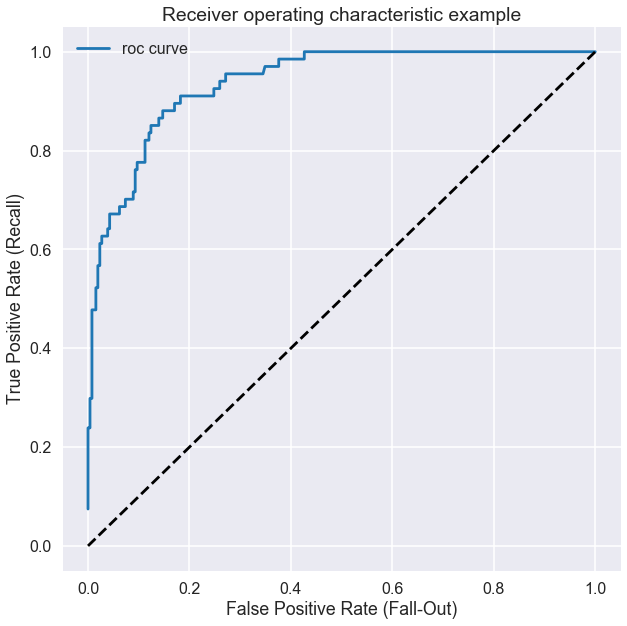

In [26]:
draw_roc()

In [27]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.937550618998033

In [28]:
for name, importance in zip(X_train.columns, model.feature_importances_):
    print(name, importance)

single_count 0.027193363048494058
freq_billboard 0.0036237052772300936
freq_genius 0.02042445063325533
freq_theSource 0.048320943955846664
freq_xxl 0.09827521170738368
twitter 0.08813296231192173
instagram 0.08895039718353867
facebook 0.040958785974519143
spotify 0.1908051255158394
soundcloud 0.1740719879712169
youtube 0.0581600898129672
genre_funk 0.0
genre_hiphop 0.013693270317899974
genre_pop 0.0765418441135443
genre_rnb 0.004367522787791372
genre_soul 0.0027618624630419654
rating 0.06371847692550951


In [29]:
scores_dict = {num_trees:[] for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
k = 10
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    scores = cross_val_score(clf, X_train, y_train, cv=k, n_jobs=-1)
    model = clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    scores_dict[num_trees].append([scores.mean(), precision, recall, f1])
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob

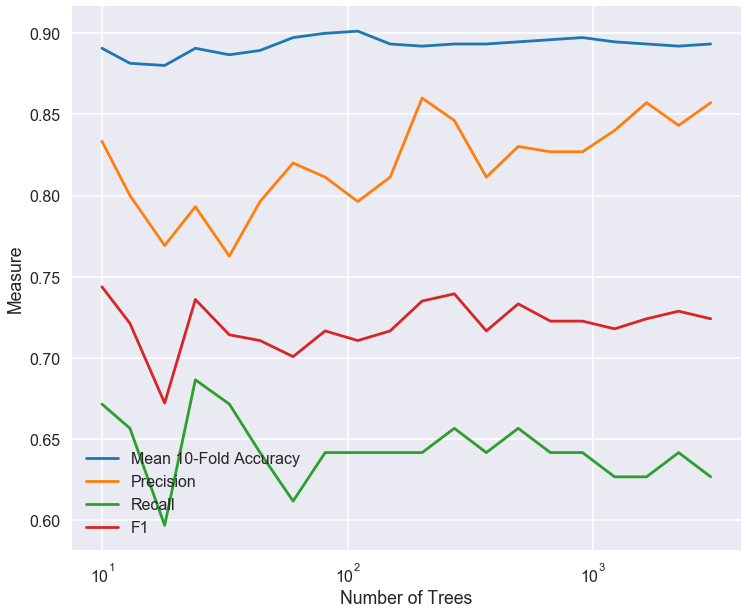

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(scores_dict.keys()),[elem[0][0] for elem in scores_dict.values()], '-', label='Mean 10-Fold Accuracy')
ax.semilogx(list(scores_dict.keys()),[elem[0][1] for elem in scores_dict.values()], '-', label='Precision')
ax.semilogx(list(scores_dict.keys()),[elem[0][2] for elem in scores_dict.values()], '-', label='Recall')
ax.semilogx(list(scores_dict.keys()),[elem[0][3] for elem in scores_dict.values()], '-', label='F1')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Measure')
# ax.set_ylim(0.89,1.)
plt.show()

# 낮게 나옴

In [31]:
from imblearn.under_sampling import *

In [41]:
for us in [ClusterCentroids, RandomUnderSampler, CondensedNearestNeighbour, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks]:
    rus = us(random_state=0)
    X_resampled_rus, y_resampled_rus = rus.fit_sample(X_train, y_train)
    model2 = RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=10,
                                min_samples_split=2 , min_samples_leaf=1
                                ).fit(X_resampled_rus, y_resampled_rus)
    print("{} : \n".format(str(us)), confusion_matrix(y_test, model2.predict(X_test)))
    print("{} : \n".format(str(us)), classification_report(y_test, model2.predict(X_test)))
    fpr, tpr, thresholds = roc_curve(y_test, model2.predict_proba(X_test)[:, 1])
    print(auc(fpr, tpr))
    "\n"

<class 'imblearn.under_sampling.prototype_generation.cluster_centroids.ClusterCentroids'> : 
 [[175  83]
 [ 12  55]]
<class 'imblearn.under_sampling.prototype_generation.cluster_centroids.ClusterCentroids'> : 
              precision    recall  f1-score   support

          0       0.94      0.68      0.79       258
          1       0.40      0.82      0.54        67

avg / total       0.83      0.71      0.73       325

0.83819275714451
<class 'imblearn.under_sampling.prototype_selection.random_under_sampler.RandomUnderSampler'> : 
 [[227  31]
 [ 12  55]]
<class 'imblearn.under_sampling.prototype_selection.random_under_sampler.RandomUnderSampler'> : 
              precision    recall  f1-score   support

          0       0.95      0.88      0.91       258
          1       0.64      0.82      0.72        67

avg / total       0.89      0.87      0.87       325

0.9300011570056693
<class 'imblearn.under_sampling.prototype_selection.condensed_nearest_neighbour.CondensedNearestNeighbou

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  idx_maj_extracted = np.delete(idx_maj, idx_maj_sample, axis=0)


### Random Under Sampling

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.25, random_state=0)

In [47]:
rus = RandomUnderSampler(random_state=0)
X_resampled_rus, y_resampled_rus = rus.fit_sample(X_train, y_train)

### grid search on number of trees

In [48]:
scores_dict = {num_trees:[] for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
k = 10
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    scores = cross_val_score(clf, X_resampled_rus, y_resampled_rus, cv=k, n_jobs=-1)
    model = clf.fit(X_resampled_rus, y_resampled_rus)
    preds = model.predict(X_test)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    scores_dict[num_trees].append([scores.mean(), precision, recall, f1])
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob

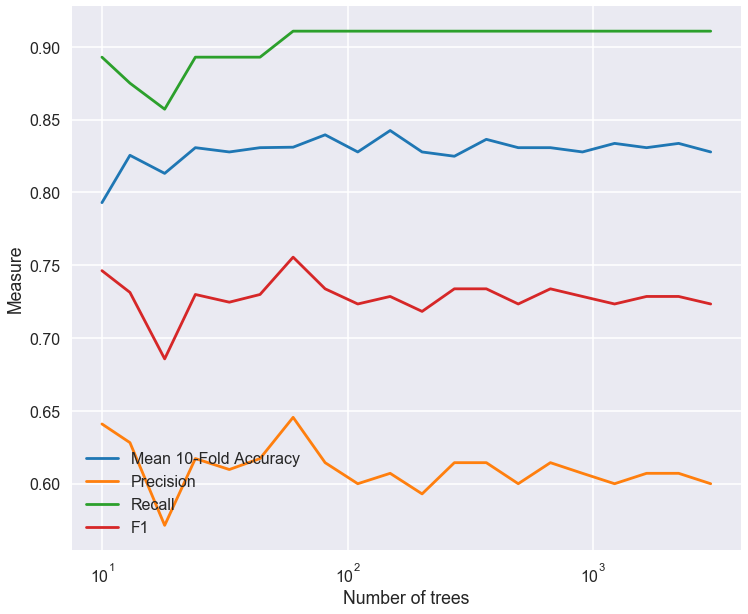

In [89]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(scores_dict.keys()),[elem[0][0] for elem in scores_dict.values()], '-', label='Mean 10-Fold Accuracy')
ax.semilogx(list(scores_dict.keys()),[elem[0][1] for elem in scores_dict.values()], '-', label='Precision')
ax.semilogx(list(scores_dict.keys()),[elem[0][2] for elem in scores_dict.values()], '-', label='Recall')
ax.semilogx(list(scores_dict.keys()),[elem[0][3] for elem in scores_dict.values()], '-', label='F1')
ax.legend()
ax.set_xlabel('Number of trees')
ax.set_ylabel('Measure')
plt.show()

- 80% 이상라는 Recall의 기준은 달성했다.
- 다음 단계는 Precision이 최고일 때의 파라미터를 찾는 것이다. 80~90개 사이의 tree에서 precision이 최고치를 나타내는 것을 볼 수 있다.

# Grid Search

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
rfc = RandomForestClassifier()

In [60]:
param_grid = {
    'bootstrap': [True],
     'class_weight': [None],
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, 3, 5, 7, 10, 12, 15],
    'max_features': ['auto'],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'min_impurity_split': [None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7],
    'min_samples_split': [2, 3, 4, 5],
    'min_weight_fraction_leaf': [0.0],
    'n_estimators': [3, 5, 7, 10, 13, 15, 17, 20, 23, 25],
    'random_state': [None],
     'oob_score': [False],
     'verbose': [0],
     'warm_start': [False]
}

In [61]:
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='recall', cv=10, n_jobs=1)

In [64]:
%%time
gs_result = gs.fit(X_resampled_rus, y_resampled_rus)

CPU times: user 1h 32min 3s, sys: 47.4 s, total: 1h 32min 50s
Wall time: 1h 37min 8s


In [65]:
gs.best_score_

0.8888888888888888

In [66]:
gs.best_params_

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [67]:
gs.score(X_test,y_test)

0.8928571428571429

# Apply GridSearchCV Best Parameter

In [84]:
model = RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=10,
                                min_samples_split=3, min_samples_leaf=4
                                ).fit(X_resampled_rus, y_resampled_rus)

In [85]:
print(confusion_matrix(y_resampled_rus, model.predict(X_resampled_rus)))

[[154  17]
 [ 13 158]]


In [86]:
print(classification_report(y_resampled_rus, model.predict(X_resampled_rus)))

             precision    recall  f1-score   support

          0       0.92      0.90      0.91       171
          1       0.90      0.92      0.91       171

avg / total       0.91      0.91      0.91       342



In [87]:
print(confusion_matrix(y_test, model.predict(X_test)))

[[179  36]
 [  5  51]]


In [88]:
print(classification_report(y_test, model.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.83      0.90       215
          1       0.59      0.91      0.71        56

avg / total       0.89      0.85      0.86       271



# Grid Search for Best Precision

In [90]:
param_grid = {
    'bootstrap': [True],
     'class_weight': [None],
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, 3, 5, 7, 10, 12, 15],
    'max_features': ['auto'],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'min_impurity_split': [None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7],
    'min_samples_split': [2, 3, 4, 5],
    'min_weight_fraction_leaf': [0.0],
    'n_estimators': [3, 5, 7, 10, 13, 15, 17, 20, 23, 25],
    'random_state': [None],
     'oob_score': [False],
     'verbose': [0],
     'warm_start': [False]
}

In [91]:
gs2 = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='precision', cv=10, n_jobs=1)

In [ ]:
%%time
gs_result = gs.fit(X_resampled_rus, y_resampled_rus)